<a href="https://colab.research.google.com/github/chindymar/Massive/blob/main/FIX_MASSIVE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IMPORT LIBRARY

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

#KAGGLE

In [4]:
!pip install -q kaggle


In [5]:
!mkdir ~/.kaggle


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
!cp kaggle.json ~/.kaggle

In [7]:
!chmod 600 ~/.kaggle/kaggle.json


#MENGUNDUH DATASET


In [8]:
!kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.20G/5.20G [02:12<00:00, 41.6MB/s]
100% 5.20G/5.20G [02:12<00:00, 42.1MB/s]


In [9]:
import zipfile


In [10]:
dataset_zip = zipfile.ZipFile("skin-cancer-mnist-ham10000.zip","r")
dataset_zip.extractall("Data_Kulit")
dataset_zip.close()

In [2]:

# Load metadata
metadata = pd.read_csv('/content/Data_Kulit/HAM10000_metadata.csv')


In [3]:
# Define image paths
image_path_1 = '/content/Data_Kulit/ham10000_images_part_1'
image_path_2 = '/content/Data_Kulit/ham10000_images_part_2'


#MEMBERSIHKAN DATA

In [ ]:
#identifikasi lesion_id yg mempunyai duplikat citra atau tidak.

def identify_duplicates(x):

    unique_list = list(df['lesion_id'])

    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'

data['duplicates'] = data['lesion_id']
data['duplicates'] = data['duplicates'].apply(identify_duplicates)

data.head()

## Menggabungkan jalur gambar dari dua direktori yang berbeda menjadi satu list.


In [4]:
image_paths = [os.path.join(image_path_1, img) for img in os.listdir(image_path_1)]
image_paths += [os.path.join(image_path_2, img) for img in os.listdir(image_path_2)]


In [5]:
print(f'Total number of images: {len(image_paths)}')


Total number of images: 10015


In [6]:
print(metadata.isnull().sum())


lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64


##Visualisasi dataset

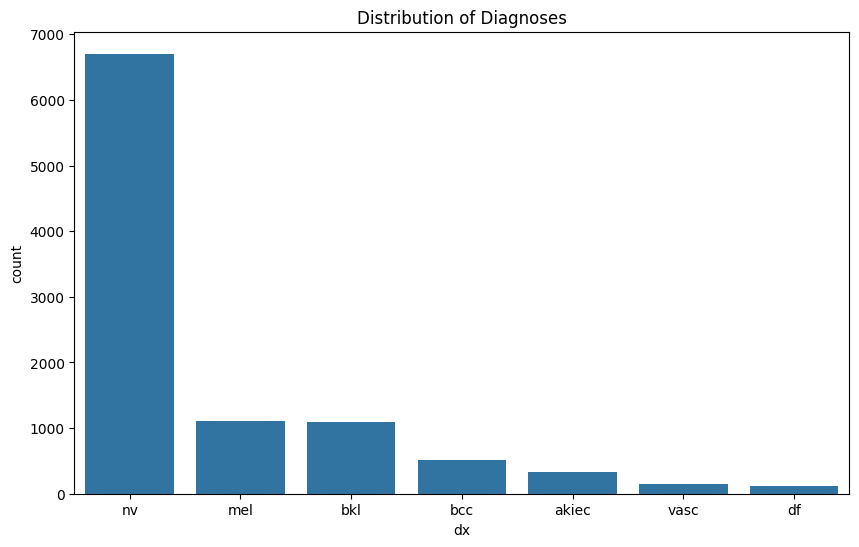

In [7]:
plt.figure(figsize=(10,6))
sns.countplot(x='dx', data=metadata, order = metadata['dx'].value_counts().index)
plt.title('Distribution of Diagnoses')
plt.show()

##Meresize setiap gambar menjadi ukuran yang sama (64x64 piksel).

In [8]:
image_size = 64
images = []
labels = []

for path in image_paths:
    image_id = os.path.splitext(os.path.basename(path))[0]
    label = metadata[metadata['image_id'] == image_id]['dx'].values[0]
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size, image_size))
    images.append(img)
    labels.append(label)

images = np.array(images)
labels = np.array(labels)


In [9]:
# Encode labels
label_mapping = {label: idx for idx, label in enumerate(np.unique(labels))}
labels = np.array([label_mapping[label] for label in labels])


#MEMPERIAPKAN DATA

##Membagi data latih dan data uji


In [10]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


##Normalisasi nilai pixel gambar di rentang 0-1

In [11]:
X_train = X_train / 255.0
X_test = X_test / 255.0


## Mengonversi label kelas menjadi representasi one-hot encoding menggunakan to_categorical dari TensorFlow-Keras.

In [12]:
y_train = to_categorical(y_train, num_classes=len(label_mapping))
y_test = to_categorical(y_test, num_classes=len(label_mapping))


##Menerapkan augmentasi data pada gambar-gambar latih

In [13]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)


#MEMBANGUN MODEL CNN

In [14]:
# Build model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(label_mapping), activation='softmax')
])


In [15]:
# Compile model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


##Melatih Model

In [16]:
# Train model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=50, validation_data=(X_test, y_test))


Epoch 1/50
251/251 [==============================] - 85s 332ms/step - loss: 1.0614 - accuracy: 0.6608 - val_loss: 1.0137 - val_accuracy: 0.6720
Epoch 2/50
251/251 [==============================] - 82s 325ms/step - loss: 1.0006 - accuracy: 0.6681 - val_loss: 0.9653 - val_accuracy: 0.6720
Epoch 3/50
251/251 [==============================] - 81s 324ms/step - loss: 0.9611 - accuracy: 0.6702 - val_loss: 0.9135 - val_accuracy: 0.6775
Epoch 4/50
251/251 [==============================] - 79s 314ms/step - loss: 0.9253 - accuracy: 0.6711 - val_loss: 0.8531 - val_accuracy: 0.6805
Epoch 5/50
251/251 [==============================] - 80s 320ms/step - loss: 0.8803 - accuracy: 0.6774 - val_loss: 0.8319 - val_accuracy: 0.6830
Epoch 6/50
251/251 [==============================] - 89s 353ms/step - loss: 0.8550 - accuracy: 0.6821 - val_loss: 0.7958 - val_accuracy: 0.6950
Epoch 7/50
251/251 [==============================] - 89s 353ms/step - loss: 0.8459 - accuracy: 0.6851 - val_loss: 0.8067 - val_ac

##EVALUASI MODEL

In [17]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')


63/63 [==============================] - 6s 88ms/step - loss: 0.6329 - accuracy: 0.7768
Test loss: 0.6328916549682617
Test accuracy: 0.7768347263336182


##Melakukan prediksi pada data uji, menampilkan confusion matrix, dan mencetaknya.


In [18]:
# Predictions and confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print(conf_matrix)


63/63 [==============================] - 4s 58ms/step
[[  19    4   17    0    4   10    0]
 [  12   44   22    1    2   25    0]
 [   4    3  107    0   17   78    0]
 [   1    7    7    0    1    7    0]
 [   5    0   33    0   71  120    0]
 [   1    1   40    0   13 1290    1]
 [   1    2    0    0    0    8   25]]


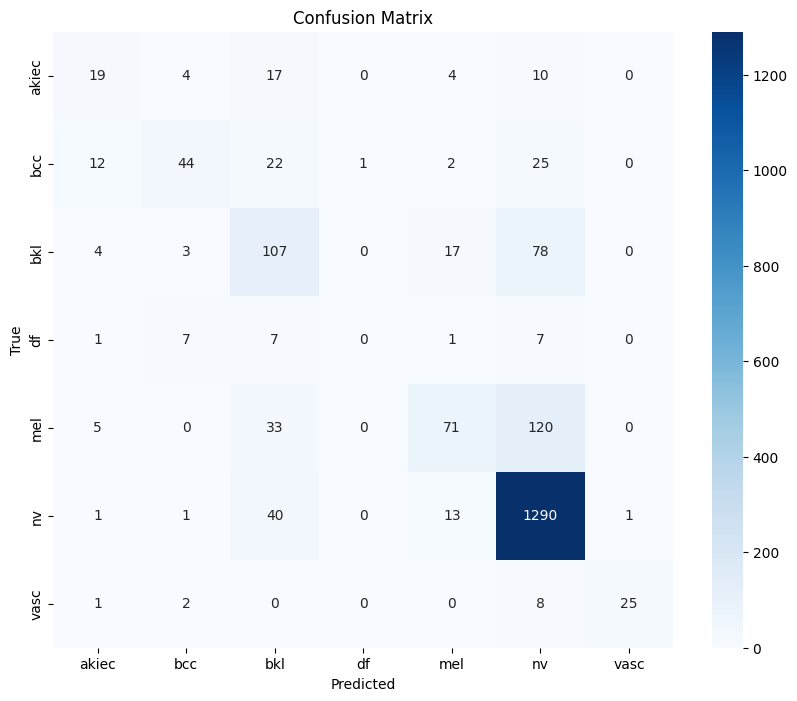

In [19]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


##Laporan klasifikasi yang mencakup precision, recall, dan f1-score untuk setiap kelas.

In [20]:

class_report = classification_report(y_true_classes, y_pred_classes, target_names=label_mapping.keys())
print(class_report)


              precision    recall  f1-score   support

       akiec       0.44      0.35      0.39        54
         bcc       0.72      0.42      0.53       106
         bkl       0.47      0.51      0.49       209
          df       0.00      0.00      0.00        23
         mel       0.66      0.31      0.42       229
          nv       0.84      0.96      0.89      1346
        vasc       0.96      0.69      0.81        36

    accuracy                           0.78      2003
   macro avg       0.58      0.46      0.50      2003
weighted avg       0.76      0.78      0.75      2003



In [31]:
# Print some example predictions
for i in range(10):  # Display 10 predictions
    print(f"Image {i+1}:")
    print(f"True Label: {list(label_mapping.keys())[y_true_classes[i]]}")
    print(f"Predicted Label: {list(label_mapping.keys())[y_pred_classes[i]]}")
    print()

Image 1:
True Label: mel
Predicted Label: nv

Image 2:
True Label: nv
Predicted Label: nv

Image 3:
True Label: bkl
Predicted Label: bkl

Image 4:
True Label: nv
Predicted Label: nv

Image 5:
True Label: bcc
Predicted Label: nv

Image 6:
True Label: nv
Predicted Label: nv

Image 7:
True Label: nv
Predicted Label: nv

Image 8:
True Label: mel
Predicted Label: nv

Image 9:
True Label: mel
Predicted Label: mel

Image 10:
True Label: nv
Predicted Label: nv



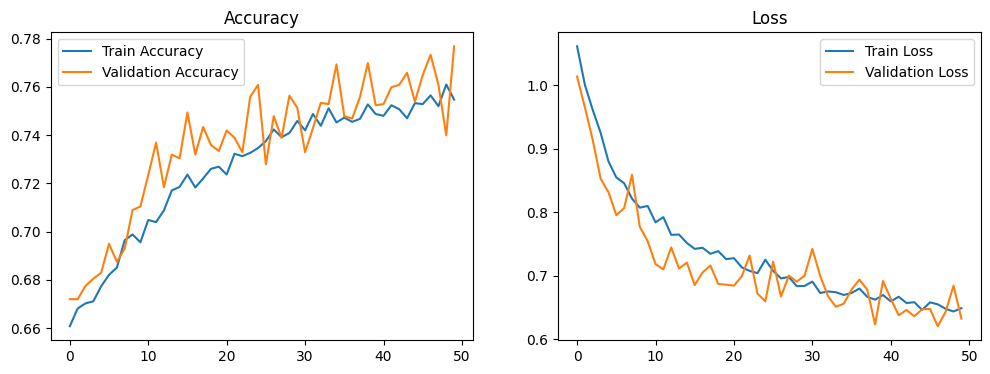

In [21]:

# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

#CONTOH PREDIKSI

In [40]:
# Function to preprocess image
preprocess_image = lambda image_path: np.expand_dims(cv2.resize(cv2.imread(image_path) / 255.0, (64, 64)), axis=0)


In [41]:
# Function to predict image
predict_image = lambda model, image_path: (
    lambda predictions: (
        {
            0: 'Actinic keratoses (AK)',
            1: 'Basal cell carcinoma (BCC)',
            2: 'Benign keratosis-like lesions (BKL)',
            3: 'Dermatofibroma (DF)',
            4: 'Melanoma (MEL)',
            5: 'Melanocytic nevi (NV)',
            6: 'Vascular lesions (VASC)',
            7: 'Bukan Kanker Kulit (UNK)'
        }[np.argmax(predictions)],
        np.max(predictions)
    )
)(model.predict(preprocess_image(image_path)))


In [42]:
# Path gambar yang akan diprediksi
example_image_path = '/content/Data_Kulit/ham10000_images_part_2/ISIC_0029306.jpg'


In [43]:
# Memanggil fungsi predict_image untuk mendapatkan prediksi kelas dan probabilitas
predicted_class, prediction = predict_image(model, example_image_path)


1/1 [==============================] - 0s 27ms/step


In [44]:
# Mencetak hasil prediksi
print("Prediksi kelas gambar:", predicted_class)
print("Probabilitas prediksi:", prediction)

Prediksi kelas gambar: Melanocytic nevi (NV)
Probabilitas prediksi: 0.9296689
